# Potato Disease Classification Using CNN

Farmers who grow potatoes suffer from serious financial standpoint losses each year which cause several diseases that affect potato plants. The diseases Early Blight and Late Blight are the most frequent. Early blight is caused by fungus and late blight is caused by specific micro-organisms and if farmers detect this disease early and apply appropriate treatment then it can save a lot of waste and prevent economical loss. The treatments for early blight and late blight are a little different so it’s important that you accurately identify what kind of disease is there in that potato plant. Behind the scene, we are going to use Convolutional Neural Network – Deep Learning to diagnose plant diseases.

Here, we’ll develop an end-to-end Deep Learning project in the field of agriculture. We will create a simple Image Classification Model that will categorize Potato Leaf Disease using a simple and classic Convolutional Neural Network Architecture.



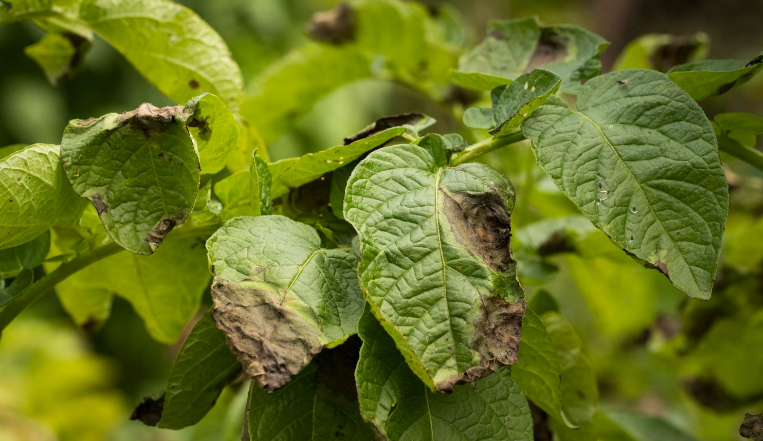

## Data collection
We will start our project by collecting data, data that can we use as a training dataset. We have 3 options for collecting data first we can use readymade data we can either buy it from a third-party vendor or get it from Kaggle etc. The second option is can have a team of Data Anatators whose job is to collect these images from farmers and annotate those images either healthy potato leaves or early or late blight diseases. So this team of annotators works with farmers, goes to the fields, and can ask farmers to take a photograph of leaves or they can take photographs themselves and they can classify them with the help of experts from the agriculture field. So they can manually collect the data. But this process will be time-consuming. The third option is writing a web-scraping script to go through different websites which has potato images collect those images and use different tools to annotate the data.

In our case, we need to collect 3 types of images, images of a healthy potato plant leaf and a potato plant that has early blight or late blight disease.

I will be using a readymade data from Kaggle: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

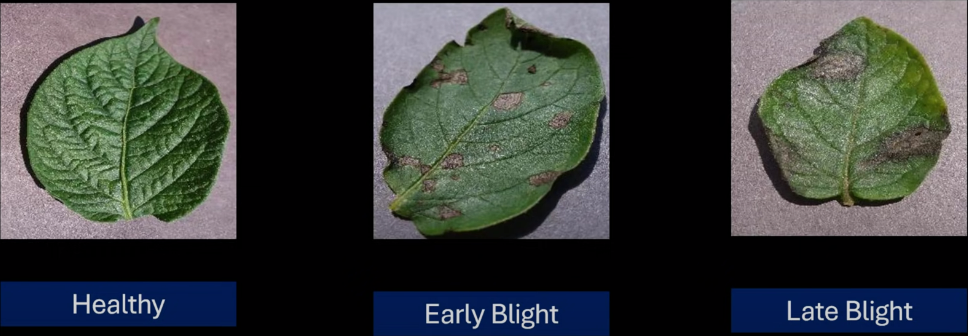

### Importing Libraries and Loading the Dataset

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
image_size = 256
batch_size = 32

df = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size
    
)

Found 2152 files belonging to 3 classes.


In [9]:
class_name = df.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 2 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 2 0 0 1]


Here we have 32 images batch, each image batch is 256x256 and 3 refers to RGB in which we have 3 channels.

In [5]:
channels = 3

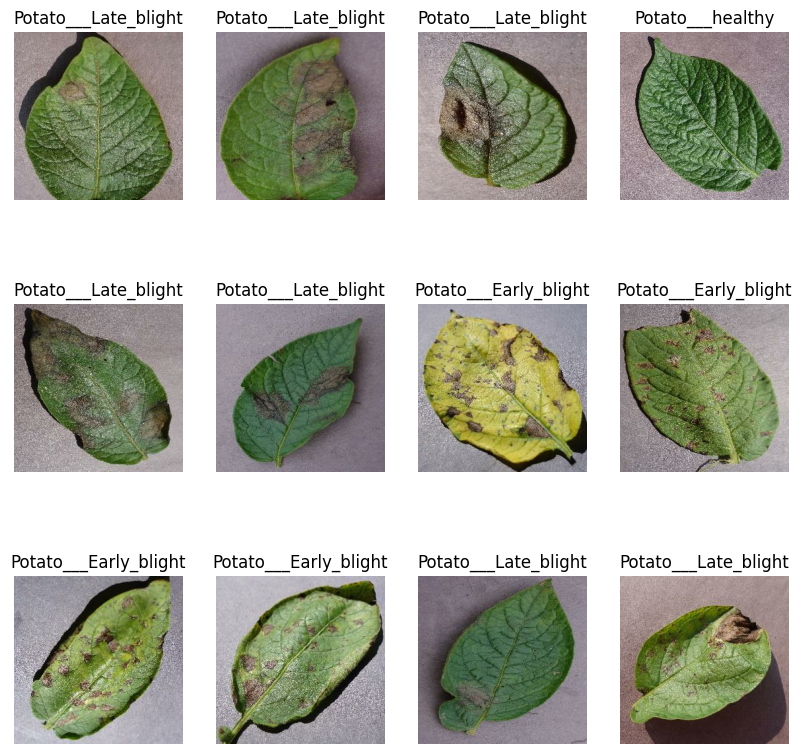

In [15]:
fig = plt.figure(figsize=(10, 10))

for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_name[label_batch[i]])

## Splitting the Data into Training, Validation, and Testing Data
I want to split the dataset into 80% training data and 20% validation and testing data.

In [16]:
len(df)

68

In [17]:
training_size = 0.8
len(df)*training_size

54.400000000000006

In [21]:
training_ds = df.take(54)  # This will give us the first 54 batch
test_ds = df.skip(54) # The will give us every batch after the batch 54.

In [22]:
val_size = 0.1
len(df)*val_size

6.800000000000001

In [23]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

Let's make a function that does all the above processes to partition the dataset

In [32]:
import math

def get_dataset_partition(df, training_size=0.8, test_size=0.1, val_size=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed=42)
    
    total_size = len(df)
    training_weight = int(training_size * total_size)
    val_weight = int(val_size * total_size)
    test_weight = total_size - training_weight - val_weight

    training_ds = df.take(training_weight)
    val_ds = df.skip(training_weight).take(val_weight)
    test_ds = df.skip(training_weight + val_weight).take(test_weight)

    return training_ds, val_ds, test_ds

training_ds, val_ds, test_ds = get_dataset_partition(df)
print(len(training_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


The below code is used to preprocess and optimize a TensorFlow Dataset (training_ds) for efficient training of machine learning models. Each part of the code serves a specific purpose:

training_ds.cache(): This line applies caching to the dataset. Caching allows TensorFlow to cache elements in memory after they are loaded for the first time. Subsequent iterations through the dataset will then use the cached data rather than re-reading it from the source. This can significantly speed up training, especially if the dataset is stored remotely or on slow storage.

.shuffle(1000): This part of the code shuffles the elements in the dataset. Shuffling is important to ensure that the model doesn't inadvertently learn any order-based patterns in the data. In this case, 1000 specifies the buffer size for shuffling. It means that TensorFlow will maintain a buffer of 1000 elements and randomly sample from it during training. You can adjust the buffer size based on your dataset size and memory constraints.

.prefetch(buffer_size=tf.data.AUTOTUNE): This line enables prefetching of elements in the dataset. Prefetching is a technique where TensorFlow loads data for the next batch in the background while the current batch is being processed. It can help minimize training time by reducing the time the model has to wait for data during training. buffer_size=tf.data.AUTOTUNE is used to automatically determine an appropriate buffer size based on available memory and CPU resources. You can specify a fixed buffer size if needed, but using tf.data.AUTOTUNE is generally recommended for optimal performance.

In [34]:
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Augmentation

In [36]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size), # This will resize all the images to 256x256
    layers.experimental.preprocessing.Rescaling(1.0/255)  # This will scale the images by dividing them over 255 (RGB)
])

In [37]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Building the Model

In [39]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [42]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [44]:
history = model.fit(
    training_ds,
    epochs = 50,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 38s 661ms/step - loss: 0.8884 - accuracy: 0.5041 - val_loss: 0.9184 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 36s 662ms/step - loss: 0.7386 - accuracy: 0.6491 - val_loss: 0.6370 - val_accuracy: 0.7135
Epoch 3/50
54/54 [==============================] - 35s 651ms/step - loss: 0.5365 - accuracy: 0.7617 - val_loss: 0.6137 - val_accuracy: 0.7656
Epoch 4/50
54/54 [==============================] - 33s 620ms/step - loss: 0.4503 - accuracy: 0.8022 - val_loss: 0.5563 - val_accuracy: 0.7344
Epoch 5/50
54/54 [==============================] - 34s 629ms/step - loss: 0.4239 - accuracy: 0.8210 - val_loss: 0.5174 - val_accuracy: 0.7865
Epoch 6/50
54/54 [==============================] - 34s 626ms/step - loss: 0.2916 - accuracy: 0.8932 - val_loss: 0.2903 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 33s 621ms/step - loss: 0.2756 - accuracy: 0.8973 - val_loss: 0.2270 - val_accuracy: 0.8854

In [45]:
score = model.evaluate(test_ds)
score

8/8 [==============================] - 2s 178ms/step - loss: 0.0944 - accuracy: 0.9805


[0.09438284486532211, 0.98046875]

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

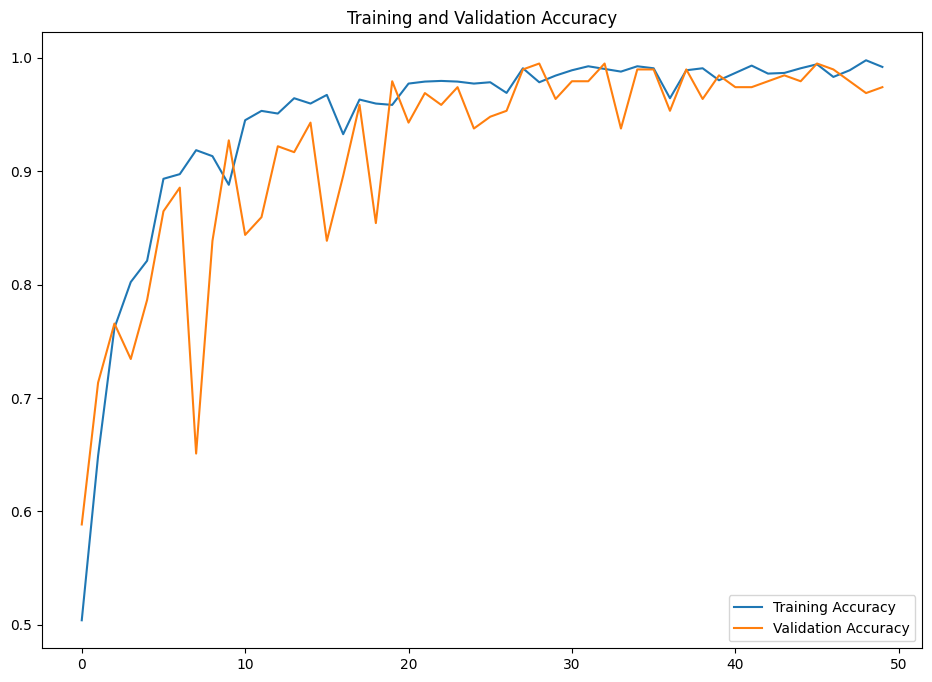

In [52]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)

plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

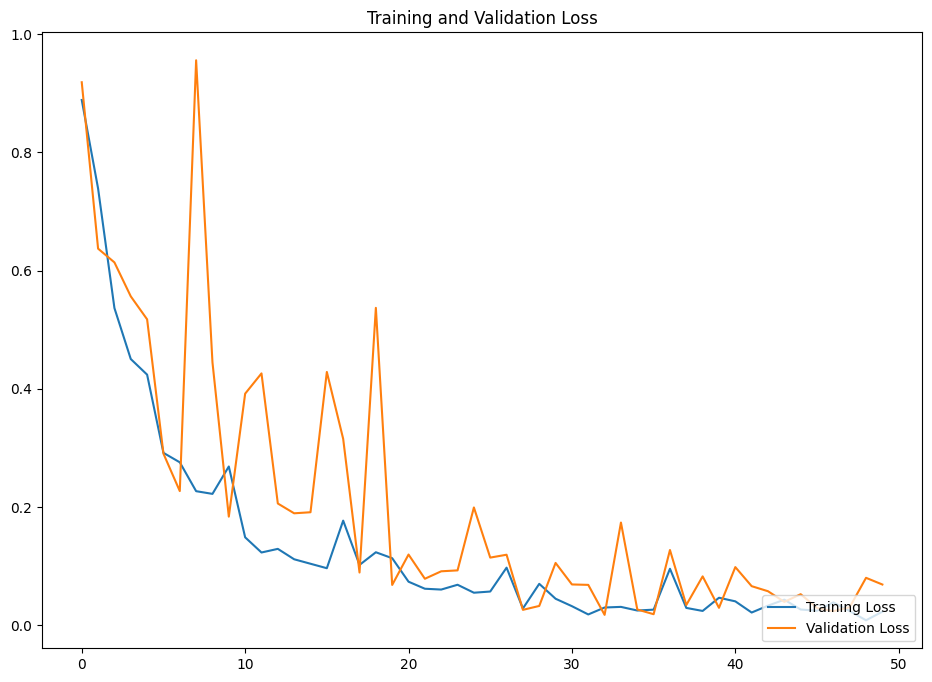

In [53]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)

plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

## Predictions

First image to predict:
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 178ms/step
Prediction result: Potato___Early_blight


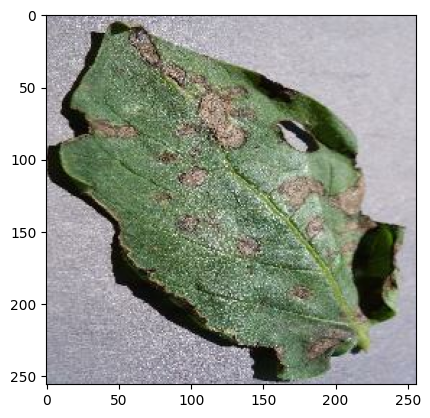

In [61]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First image to predict:')
    plt.imshow(first_image)
    print(f'Actual label: {class_name[first_label]}')

    batch_pred = model.predict(image_batch)
    print(f'Prediction result: {class_name[np.argmax(batch_pred[0])]}')

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


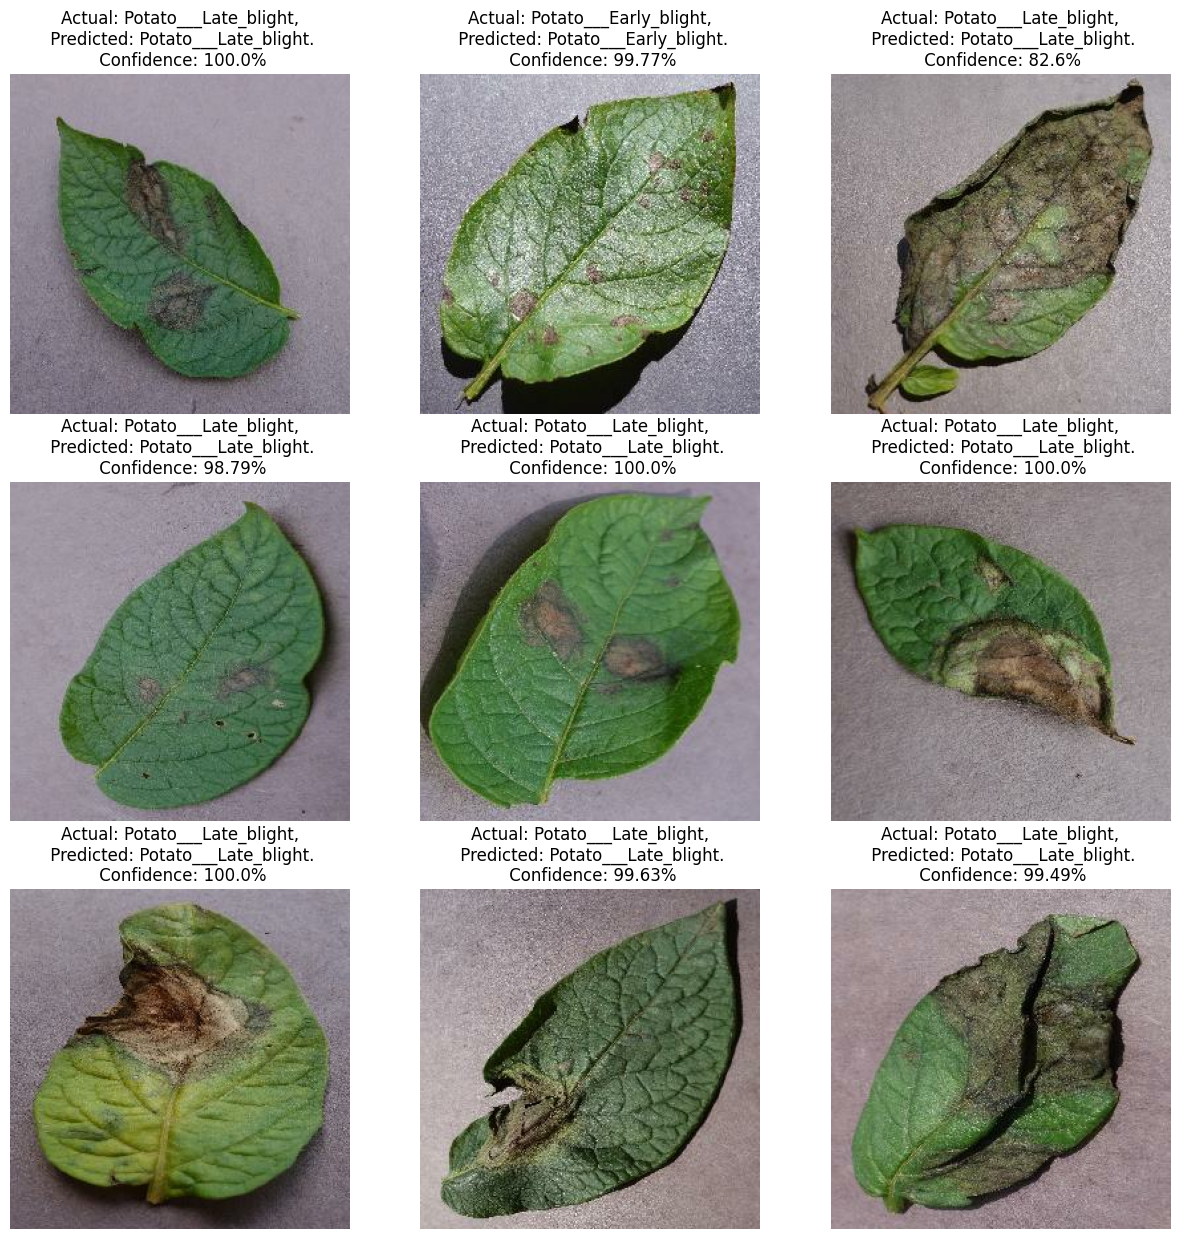

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the model

In [69]:
import warnings
warnings.filterwarnings('ignore')

model.save('potatoes.h5')